# ALeRCE classes

https://github.com/ZwickyTransientFacility/ztf-avro-alert

1. **AGN:** Active Galactic Nuclei
1. **Blazar:** Blazar
1. **CV/Nova:** Cataclysmic Variable Star/Nova
1. **Ceph:** Cepheid Variable Star
1. **DSCT:** Delta Scuti Star
1. **EA:** Eclipsing Algol
1. **EB/EW:** Eclipsing Binaries/Eclipsing W Ursa Majoris
1. **LPV:** Long Period Variable
1. **Periodic-Other:** Periodic-Other
1. **QSO:** Quasi-Stellar Object
1. **RRL:** RRLyrae Variable Star
1. **RSCVn:** RS Canum Venaticorum
1. **SLSN:** Super Luminous Supernova
1. **SNII:** Supernova II
1. **SNIIb:** Supernova IIb
1. **SNIIn:** Supernova IIn
1. **SNIa:** Supernova Ia
1. **SNIbc:** Supernova Ibc
1. **TDE:** Tidal disruption event (to remove)
1. **YSO:** Young Stellar Object
1. **ZZ:** ZZ Ceti Stars (to remove)

In [1]:
import numpy as np
import pandas as pd

def subset_df_columns(df, subset_cols):
    df_cols = list(df.columns)
    return df[[c for c in subset_cols if c in df_cols]]

def set_index(df, index_name):
    if not df.index.name is None and df.index.name==index_name:
        return df
    df_cols = list(df.columns)
    assert index_name in df_cols
    return df.set_index([index_name])

def df_to_float32(df):
    for c in df.columns:
        if df[c].dtype=='float64':
            df[c] = df[c].astype(np.float32)

In [2]:
import numpy as np
import pandas as pd

load_rootdir = '/home/opimentel/tesis/surveys_data'
survey_name = 'alerceZTFv7.1'
df_index_names = {
    'oid':'oid', # object id
    'oid_det':'objectId', # object id
    'label':'classALeRCE', # object class name
    'ra':'ra',
    'dec':'dec',
    'band':'fid', # band
    'obs_day':'mjd', # days
    'obs':'magpsf_corr', # observations
    'obs_error':'sigmapsf_corr', # observation errors
}
subset_columns_names = {
    'labels':['oid', 'classALeRCE', 'ra', 'dec'],
    'detections':['objectId', 'fid', 'mjd', 'magpsf_corr', 'sigmapsf_corr'],
}

### load files and processing
labels_df = pd.read_csv(f'{load_rootdir}/{survey_name}/dfcrossmatches_prioritized_v7.0.1.csv')
print(f'labels - columns: {list(labels_df.columns)} - id: {labels_df.index.name}')
labels_df = subset_df_columns(labels_df, subset_columns_names['labels']) # sub sample columns
labels_df = set_index(labels_df, df_index_names['oid']) # set index

detections_df = pd.read_parquet(f'{load_rootdir}/{survey_name}/detections_with_xmatch')
print(f'detections_df - columns: {list(detections_df.columns)} - id: {detections_df.index.name}')
invalid_objs = list(set(np.concatenate([
    detections_df.loc[detections_df['isdiffpos']==-1].index,
    detections_df.loc[detections_df['sigmapsf_corr']>=100].index,
], axis=0)))
detections_df = subset_df_columns(detections_df, subset_columns_names['detections']) # sub sample columns
detections_df = set_index(detections_df, df_index_names['oid_det']) # set index
detections_df.index.rename(df_index_names['oid'], inplace=True)
df_to_float32(detections_df)

### filter
print('invalid_objs',invalid_objs)
detections_df = detections_df.drop(index=invalid_objs, errors='ignore')
labels_df = labels_df.drop(index=invalid_objs, errors='ignore')

### print info
classes = np.unique(labels_df[df_index_names['label']].values)
print('classes:', classes)

labels - columns: ['oid', 'classALeRCE', 'ra', 'dec', 'period', 'source', 'id_source', 'class_source', 'separation_arcsec'] - id: None
detections_df - columns: ['fid', 'isdiffpos', 'sigmapsf', 'field', 'fwhm', 'dec', 'magpsf', 'rcid', 'ra', 'sky', 'rb', 'ssmagnr', 'distpsnr3', 'sgscore2', 'maggaiabright', 'distpsnr2', 'distpsnr1', 'maggaia', 'exptime', 'drb', 'sgscore3', 'neargaia', 'sgscore1', 'mjd', 'corrected', 'magpsf_corr', 'sigmapsf_corr', 'sigmapsf_corr_ext', 'dubious', 'has_stamp'] - id: objectId
invalid_objs ['ZTF18aczdxce', 'ZTF19aatoqph', 'ZTF18abifepy', 'ZTF18acrukwe', 'ZTF18abslcyv', 'ZTF18abcolsv', 'ZTF19abesdrh', 'ZTF18acrvtai', 'ZTF18abgdtna', 'ZTF19aamhmum', 'ZTF17aaajpfi', 'ZTF17aacnufo', 'ZTF19aascobu', 'ZTF19aaeqntc', 'ZTF20aagiaai', 'ZTF18adbimpk', 'ZTF18acwwncx', 'ZTF17aabtqsd', 'ZTF18acruzww', 'ZTF18aaavkxc', 'ZTF19aaxpjzv', 'ZTF18abodqqq', 'ZTF19aaukdoh', 'ZTF18acxagls', 'ZTF18aaxwjxd', 'ZTF19aangszi', 'ZTF18abjffzu', 'ZTF18abpnurs', 'ZTF18aaqdupm', 'ZTF18abdxzg

classes: ['AGN' 'Blazar' 'CV/Nova' 'Ceph' 'DSCT' 'EA' 'EB/EW' 'LPV' 'NLAGN' 'NLQSO'
 'Periodic-Other' 'QSO' 'RRL' 'RSCVn' 'SLSN' 'SNII' 'SNIIb' 'SNIIn' 'SNIa'
 'SNIbc' 'YSO' 'ZZ']


In [3]:
labels_df.info()
labels_df[:10]

<class 'pandas.core.frame.DataFrame'>
Index: 45865 entries, ZTF18acejdhu to ZTF19abeesgk
Data columns (total 3 columns):
classALeRCE    45865 non-null object
ra             45865 non-null float64
dec            45865 non-null float64
dtypes: float64(2), object(1)
memory usage: 1.4+ MB


,classALeRCE,ra,dec
oid,,,
ZTF18acejdhu,AGN,11.958444,-10.496615
ZTF18acdzene,AGN,17.478620,-10.110250
ZTF18abwzuzw,AGN,25.038255,-10.352430
ZTF19abeytti,AGN,321.623931,10.576962
ZTF18abwvoze,AGN,323.925552,0.551960
ZTF19aawscoj,AGN,342.102634,0.155742
ZTF19abajoiw,AGN,344.068087,12.815895
ZTF18acejzfg,AGN,355.791788,0.547669
ZTF19aawlmkl,AGN,343.048934,14.690138


In [4]:
detections_df.info()
detections_df[:100]

<class 'pandas.core.frame.DataFrame'>
Index: 1534065 entries, ZTF18aavejan to ZTF20abcxmfu
Data columns (total 4 columns):
fid              1534065 non-null int64
mjd              1534065 non-null float32
magpsf_corr      1442212 non-null float32
sigmapsf_corr    1442212 non-null float32
dtypes: float32(3), int64(1)
memory usage: 41.0+ MB


,fid,mjd,magpsf_corr,sigmapsf_corr
oid,,,,
ZTF18aavejan,1,58307.351562,NaN,NaN
ZTF18aavejan,1,58812.121094,NaN,NaN
ZTF18aavejan,1,58376.210938,NaN,NaN
ZTF18aavejan,1,58812.109375,NaN,NaN
ZTF18aavejan,1,59038.289062,NaN,NaN
ZTF18aavejan,1,58612.414062,NaN,NaN
ZTF18aavejan,1,58377.257812,NaN,NaN
ZTF18aavejan,1,58776.121094,NaN,NaN
ZTF18aavejan,1,58429.171875,NaN,NaN


In [5]:
import sys
sys.path.append('../../../')
sys.path.append('../../../../flaming-choripan')

label_to_class_dict: {'AGN': 'AGN', 'Blazar': 'Blazar', 'CV/Nova': 'CV/Nova', 'Ceph': 'Ceph', 'DSCT': 'DSCT', 'EA': 'EA', 'EB/EW': 'EB/EW', 'LPV': 'LPV', 'NLAGN': 'NLAGN', 'NLQSO': 'NLQSO', 'Periodic-Other': 'Periodic-Other', 'QSO': 'QSO', 'RRL': 'RRL', 'RSCVn': 'RSCVn', 'SLSN': 'SLSN', 'SNII': 'SNII', 'SNIIb': 'SNIIb', 'SNIIn': 'SNIIn', 'SNIa': 'SNIa', 'SNIbc': 'SNIbc', 'YSO': 'YSO', 'ZZ': 'ZZ'}
label_to_class_dict: 
	AGN: AGN
	Blazar: Blazar
	CV/Nova: CV/Nova
	Ceph: Ceph
	DSCT: DSCT
	EA: EA
	EB/EW: EB/EW
	LPV: LPV
	NLAGN: NLAGN
	NLQSO: NLQSO
	Periodic-Other: Periodic-Other
	QSO: QSO
	RRL: RRL
	RSCVn: RSCVn
	SLSN: SLSN
	SNII: SNII
	SNIIb: SNIIb
	SNIIn: SNIIn
	SNIa: SNIa
	SNIbc: SNIbc
	YSO: YSO
	ZZ: ZZ
class_to_label_dict: 
	AGN: AGN
	Blazar: Blazar
	CV/Nova: CV/Nova
	Ceph: Ceph
	DSCT: DSCT
	EA: EA
	EB/EW: EB/EW
	LPV: LPV
	NLAGN: NLAGN
	NLQSO: NLQSO
	Periodic-Other: Periodic-Other
	QSO: QSO
	RRL: RRL
	RSCVn: RSCVn
	SLSN: SLSN
	SNII: SNII
	SNIIb: SNIIb
	SNIIn: SNIIn
	SNIa: SNIa
	SNIbc: 

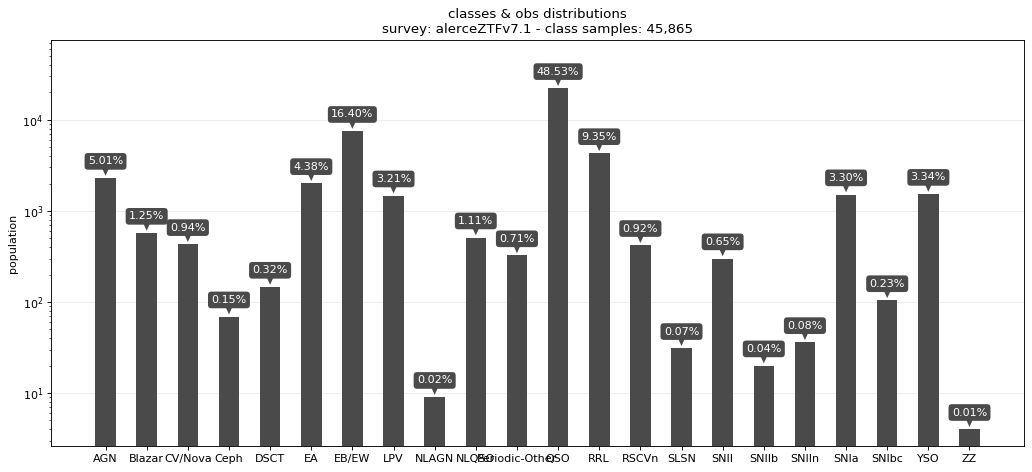

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from lchandler.survey_export.utils import LightCurveDictionaryCreator

band_dictionary = {
    'g':1,
    'r':2,
}
args = [survey_name, detections_df, labels_df, band_dictionary, df_index_names]
kwargs = {
    'obs_is_flux':False,
    'remove_negative_fluxes':True,
    'zero_point':48.6,
    #'maximum_samples_per_class':5000,
}
lcDictionaryCreator = LightCurveDictionaryCreator(*args, **kwargs)
lcDictionaryCreator.plot_class_distribution(figsize=(13,6), uses_log_scale=True)

to_merge_classes_key: merSNII
labels_df:
             classALeRCE          ra        dec
oid                                            
ZTF18acqyvag        SLSN  143.373151   0.052342
ZTF19aarphwc        SLSN  270.124769  50.295362
ZTF18acxgqxq        SLSN  348.747166  48.757691
ZTF18abshezu        SLSN  359.324773 -15.631473
ZTF19aanesgt        SLSN  124.474710  65.479597
ZTF18acyxnyw        SLSN  186.984299  56.393212
ZTF19aalbrph        SLSN  256.995171  58.701078
ZTF19aaruixj        SLSN  209.415737  64.355184
ZTF19aamhhiz        SLSN  213.768594  50.651885
ZTF19abaeyqw        SLSN  212.082422   8.966947
ZTF19aaqrime        SLSN  294.844151  78.762121
ZTF19abpbopt        SLSN  268.611413  47.261271
ZTF19abnacvf        SLSN   13.006061   7.616605
ZTF19abuyuwa        SLSN   15.299022  14.026501
ZTF19acfwynw        SLSN    2.554764 -19.692340
ZTF20aahbfmf        SLSN  124.061047   4.324134
ZTF18ablwafp        SLSN  313.654810  22.081004
ZTF20aayprqz        SLSN  233.259553  67.913469

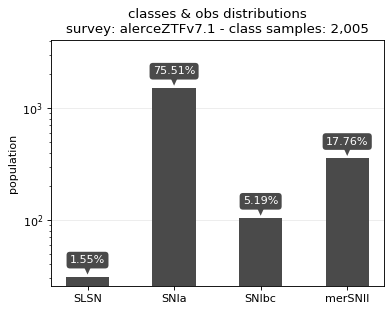

In [7]:
DF_INVALID_CLASSES = ['ZZ']
DF_SN_LIST = ['SLSN' ,'SNII', 'SNIIb', 'SNIIn', 'SNIa', 'SNIbc']

#mode = 'raw'
#mode = 'simple'
#mode = 'transients'
#mode = 'RRCeph'
mode = 'onlySNe'
#mode = 'onlySNIa'

if mode=='simple':
    invalid_classes = DF_INVALID_CLASSES
    query_classes = []
    to_merge_classes_dic = {'SN':DF_SN_LIST,}
    
elif mode=='onlySNe':
    invalid_classes = DF_INVALID_CLASSES
    query_classes = DF_SN_LIST
    to_merge_classes_dic = {'merSNII':['SNII', 'SNIIb', 'SNIIn'],}
    
elif mode=='onlySNIa':
    invalid_classes = DF_INVALID_CLASSES
    query_classes = DF_SN_LIST
    to_merge_classes_dic = {'nonSNIa':['SLSN' ,'SNII', 'SNIIb', 'SNIIn', 'SNIbc'],}

elif mode=='RRCeph':
    invalid_classes = DF_INVALID_CLASSES
    query_classes = ['RRL','Ceph']
    to_merge_classes_dic = {}

lcDictionaryCreator.update_labels_df(invalid_classes, query_classes, to_merge_classes_dic)
lcDictionaryCreator.plot_class_distribution(figsize=(5,4), uses_log_scale=True)

In [8]:
%load_ext autoreload
%autoreload 2

description = 'ZTF Alerce'
save_folder = f'/home/opimentel/tesis/astro-lightcurves-handler/save/{survey_name}'
filename_extra_parameters = {
    'mode':mode,
}
kwargs = {
    'to_export_bands':list(band_dictionary.keys()),
    #'to_export_bands':['g','r'],
    #'SCPD_probs':C_.DEFAULT_SCPD_PS,
    'filename_extra_parameters':filename_extra_parameters,
    'saves_every':1e5,
}
raw_lcdataset = lcDictionaryCreator.export_dictionary(description, save_folder, **kwargs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
lcobj_names examples: ['ZTF17aabwypb', 'ZTF18aaajyea', 'ZTF18aaegvyd', 'ZTF18aahmrtf', 'ZTF18aahvndq', 'ZTF18aailmnv', 'ZTF18aajkivu', 'ZTF18aaodrgt', 'ZTF18aaqeasu', 'ZTF18aaqnrum']
to_export_bands: ['g', 'r']
cleaning the DataFrame... - original samples: 1,534,065
remove_invalid_bands - samples: 1,534,019
remove_invalid_classes - samples: 93,675
drop_nans - samples: 25,755
remove_negative_fluxes - samples: 25,755
creating dask DataFrame - npartitions: 4 ...
filedir: /home/opimentel/tesis/astro-lightcurves-handler/save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe.rawlcd
easy_label_dict: {'SLSN': 0, 'SNIa': 1, 'SNIbc': 2, 'merSNII': 3}
100%|██████████| 2005/2005 [216.70it/s, obj: ZTF20abijfqq - y: None - lengths_bdict: None - pass_cond: False - correct_samples: 628]            
last dictionary save! filedir: /home/opimentel/tesis/astro-lightcurves-handler/save/alerceZTFv7.1/survey-alerce

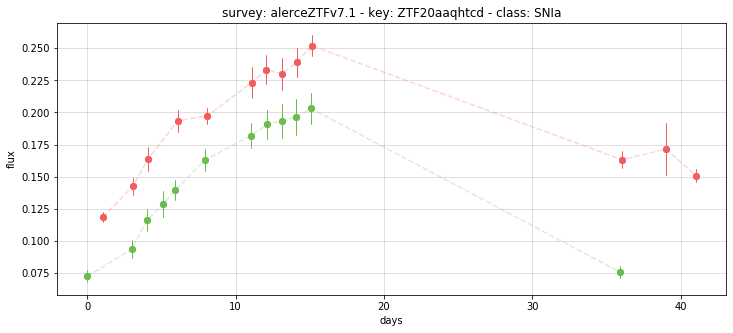

In [13]:
import flamingchoripan.lists as lists
import matplotlib.pyplot as plt
from lchandler.plots.lc import plot_lightcurve

lcset = raw_lcdataset['raw']
lcobj, key = lcset.get_random_lcobj()
fig, ax = plt.subplots(1,1, figsize=(12,5))
for kb,b in enumerate(lcset.band_names):
    plot_lightcurve(ax, lcobj, b)
ax.set_title(f'survey: {lcset.survey} - key: {key} - class: {lcset.class_names[lcobj.y]}')
ax.set_xlabel('days')
ax.set_ylabel('flux')
ax.grid(alpha=0.5)